# Spectroscopy of atom lights

The goal is to identify the atoms

In [1]:
# %matplotlib ipympl # for interactive plots

import imageio.v2 as imageio
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

In [13]:
import sys
sys.path.append("..")
import xspectra.utils as utils
import xspectra.atom as atom
import xspectra.visualization as vis

## Load data

In [3]:
data_folder = "./data/atom_lights"
filename = "one_shot.SPE" # Ne-Ar light at lambda = 540 nm
data = utils.load_data(os.path.join(data_folder, filename))


## Show the raw & filtered data

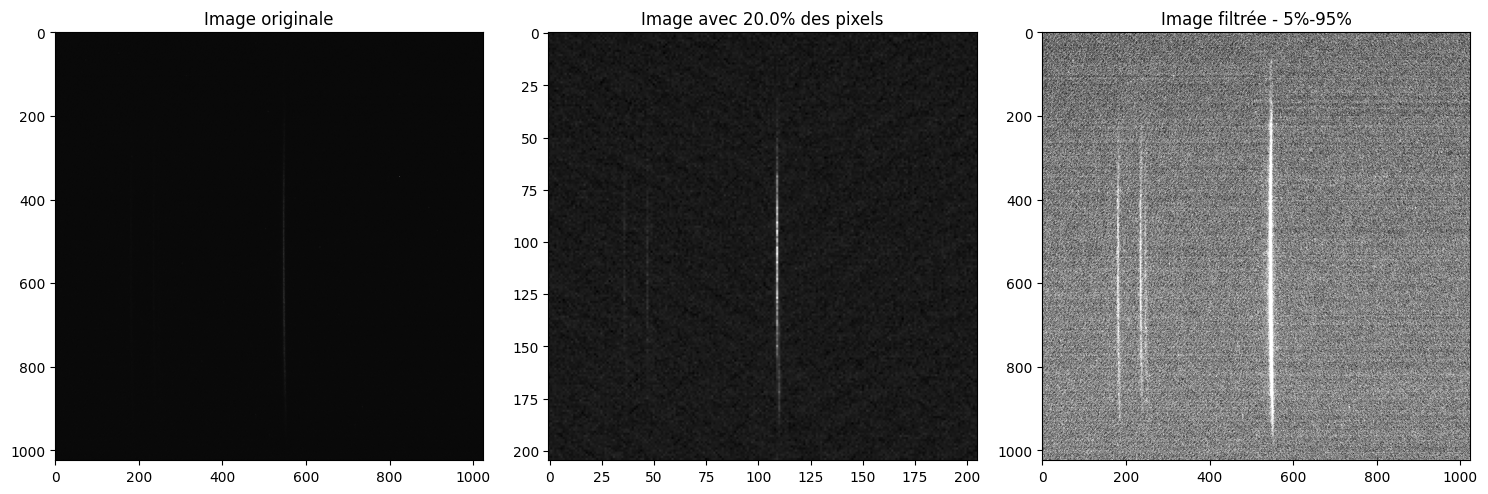

In [4]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Premier graphique
ratio_quality = 1
axs[0].imshow(data[::ratio_quality, ::ratio_quality], cmap='gray')
axs[0].set_title('Image originale')

# Deuxième graphique
ratio_quality = 5
axs[1].imshow(data[::ratio_quality, ::ratio_quality], cmap='gray')
axs[1].set_title(f'Image avec {100/ratio_quality}% des pixels')

# Troisième graphique
ratio_quality = 1
filter_value = 5
filtered_data = utils.filter_data(data, filter_value)
axs[2].imshow(filtered_data[::ratio_quality, ::ratio_quality], cmap='gray')
axs[2].set_title(f'Image filtrée - {filter_value}%-{100-filter_value}%')

plt.tight_layout()
plt.savefig("./res/filtering.png")
plt.show()


## Extract spectrum

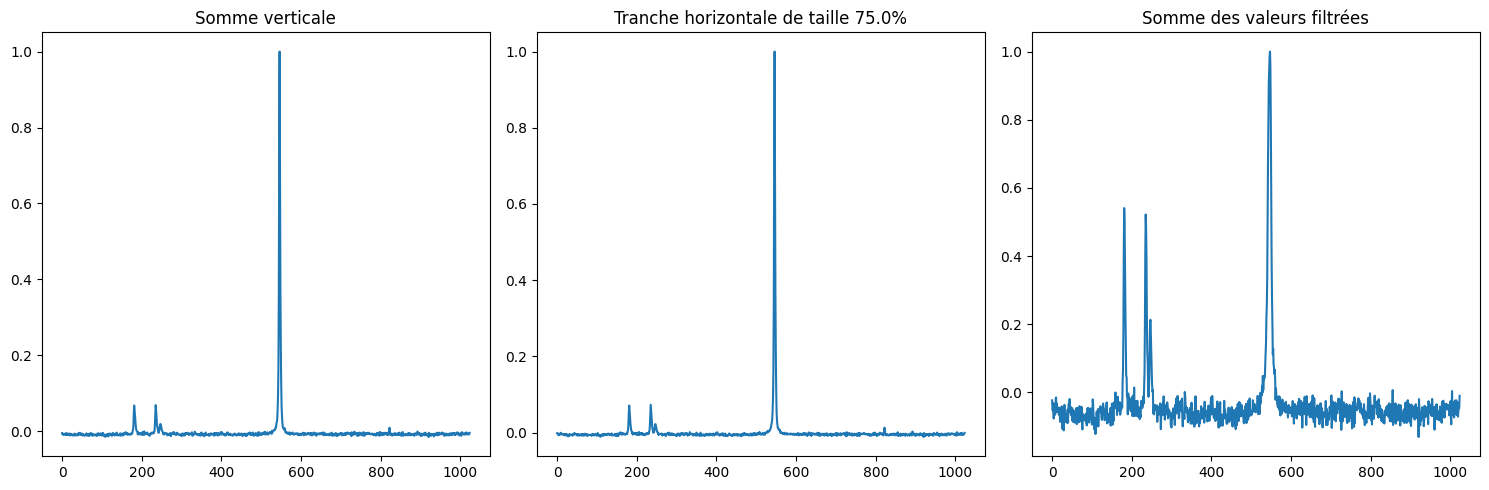

In [5]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
full_path = os.path.join(data_folder, filename)

# Graphe pour la somme verticale
axs[0].plot(utils.extract_spectrum(full_path, cut_proportion=None, filter_data_value=None))
axs[0].set_title('Somme verticale')

# Graphe pour la tranche horizontale
axs[1].plot(utils.extract_spectrum(full_path, cut_proportion=0.75, filter_data_value=None))
axs[1].set_title(f'Tranche horizontale de taille {0.75*100}%')

# Graphe pour la somme des valeurs filtrées
axs[2].plot(utils.extract_spectrum(full_path, cut_proportion=0.75, filter_data_value=5))
axs[2].set_title('Somme des valeurs filtrées')

plt.tight_layout()
plt.show()
# plt.savefig("spectrum.png")

## Analyse des lampes

In [6]:
file = "light1.SPE"
full_path = os.path.join(data_folder, file)


# data_l1 = imageio.imread(file)

# spectrum_l1 = np.sum(data_l1, axis=0)
# spectrum_l1 /= max(spectrum_l1) # Normalisation de l'intensité

spectrum_l1 = utils.extract_spectrum(full_path, cut_proportion=0.75, filter_data_value=None, normalize=True)


# we get the wavelengths by knowing the resolution of the spectrometer
# and the range of wavelengths
resolution = 36.6739e-12
largeur_plage = len(spectrum_l1)*resolution

l_min = 200e-9
l_max = 850e-9

longueurs_onde = np.linspace(l_min, l_max, len(spectrum_l1))* 1e9



## Extraction des raies

Pour cela on utilise [find_peaks](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks.html) de `scipy`

<Figure size 640x480 with 0 Axes>

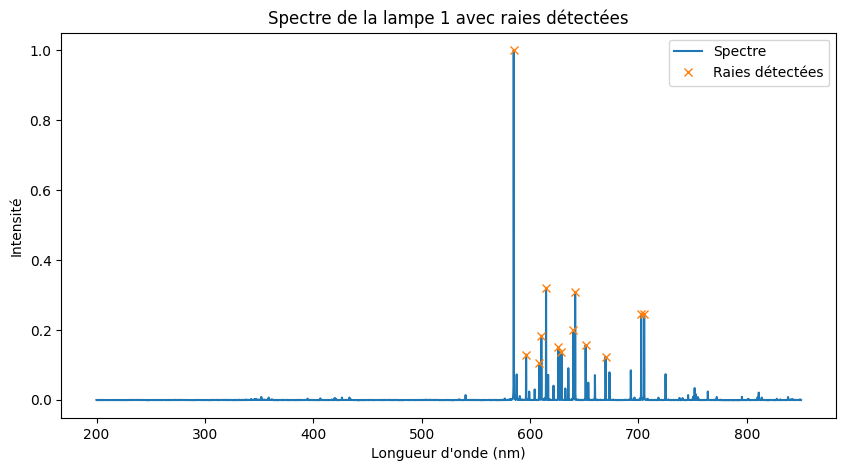

Longueurs d'onde des raies détectées (nm):
13


<Figure size 640x480 with 0 Axes>

In [7]:
from scipy.signal import find_peaks # très utile pour détecter les pics dans un spectre
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks.html

# Détection des pics dans le spectre
peaks, _ = find_peaks(spectrum_l1, height=0.1) # On fixe une hauteur minimale


# Affichage du spectre avec les pics détectés
plt.clf()
plt.figure(figsize=(10, 5))
plt.plot(longueurs_onde, spectrum_l1, label='Spectre')
plt.plot(longueurs_onde[peaks], spectrum_l1[peaks], 'x', label='Raies détectées')
plt.xlabel("Longueur d'onde (nm)")
plt.ylabel("Intensité")
plt.title("Spectre de la lampe 1 avec raies détectées")
plt.legend()
plt.show()

plt.savefig("spectre_l1.png")

# Affichage des longueurs d'onde des raies détectées
raies_detectees = longueurs_onde[peaks]
print("Longueurs d'onde des raies détectées (nm):")
print(len(raies_detectees))

In [8]:
# Exemple d'utilisation
raies_l1 = longueurs_onde[utils.extract_raies(spectrum_l1)]
raies_l1

array([540.51286391, 584.9243963 , 587.63823065, 590.49875875,
       596.32983525, 599.19036335, 604.25129768, 608.35872264,
       610.37576168, 614.7399007 , 616.64691943, 621.63450688,
       626.18201309, 628.96919431, 632.52651772, 635.2770255 ,
       639.78785827, 641.58485669, 651.2666441 , 653.68709095,
       659.84822839, 669.64003611, 673.23403295, 692.96434213,
       702.49943579, 705.24994358, 725.0169262 , 745.77409163,
       751.82520876, 752.81539156, 763.96411645, 810.97946288])

## Extract references from the web

In [15]:
atoms = ["Ne I", "Ar I"]
rays = [atom.get_best_rays(a, top=10)[0] for a in atoms]

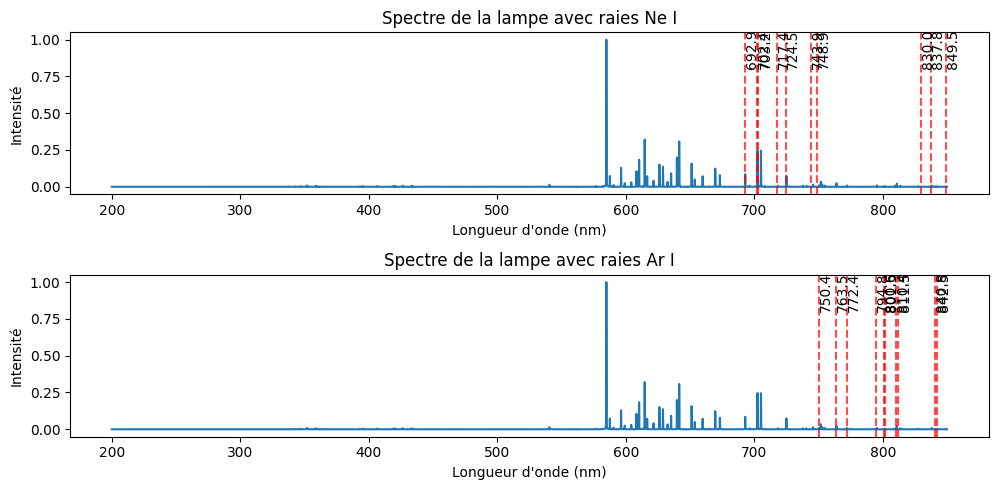

In [16]:
vis.plot_spectra_with_rays(spectrum_l1, longueurs_onde, rays, spectra_output="spectra_with_rays.png")

In [17]:
# Exemple d'utilisation
scores = [utils.score_rays(raies_l1, raies_atom) for raies_atom in rays]
nb_matches = [utils.get_nb_matches(raies_l1, raies_atom) for raies_atom in rays]
for atom,score, nb_m in zip(atoms, scores, nb_matches):
    print(f"Atome: {atom}")
    print(f"\tScore des raies {atom}: {score:.2f}")
    print(f"\tNombre de raies détectées pour {atom}: {nb_m}")

AttributeError: module 'xspectra.utils' has no attribute 'score_rays'

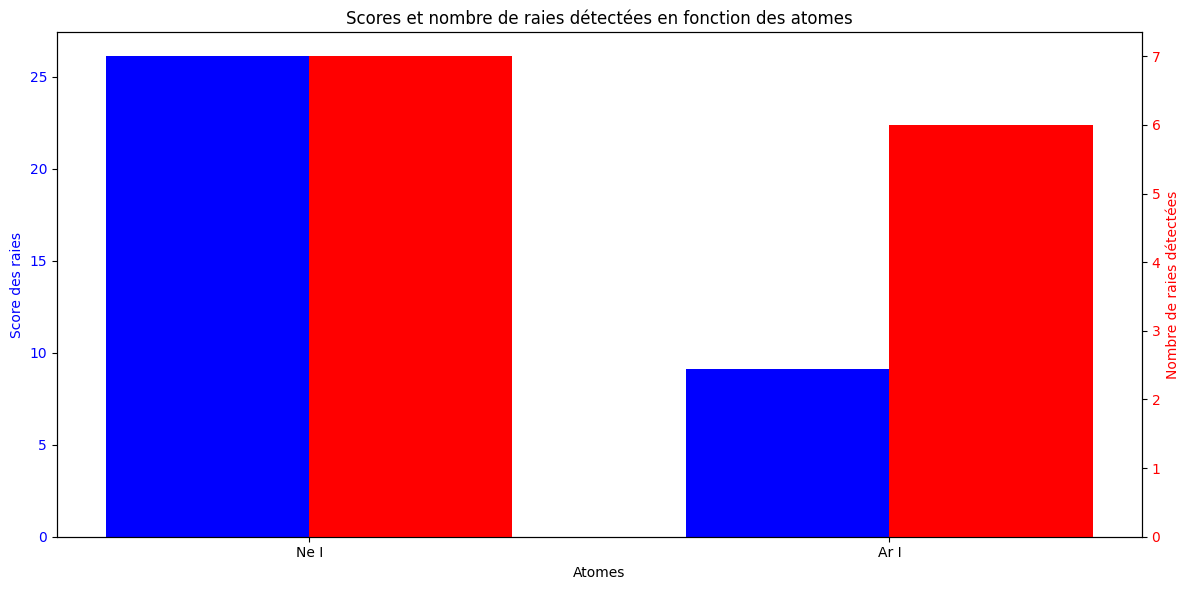

In [ ]:
def plot_scores_and_matches(atoms, scores, nb_matches, scores_output=None):
    # Trier les atomes par ordre décroissant des matchs
    sorted_indices = np.argsort(nb_matches)[::-1]
    sorted_atoms = [atoms[i] for i in sorted_indices]
    sorted_scores = [scores[i] for i in sorted_indices]
    sorted_nb_matches = [nb_matches[i] for i in sorted_indices]

    # Configuration des barres
    x = np.arange(len(sorted_atoms))  # la position des atomes
    width = 0.35  # la largeur des barres

    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Barres pour les scores
    bars1 = ax1.bar(x - width/2, sorted_scores, width, label='Score des raies', color='b')
    ax1.set_xlabel('Atomes')
    ax1.set_ylabel('Score des raies', color='b')
    ax1.tick_params(axis='y', labelcolor='b')

    # Créer un deuxième axe pour le nombre de matchs
    ax2 = ax1.twinx()
    bars2 = ax2.bar(x + width/2, sorted_nb_matches, width, label='Nombre de raies détectées', color='r')
    ax2.set_ylabel('Nombre de raies détectées', color='r')
    ax2.tick_params(axis='y', labelcolor='r')

    # Ajouter des labels, titre et légende
    ax1.set_title('Scores et nombre de raies détectées en fonction des atomes')
    ax1.set_xticks(x)
    ax1.set_xticklabels(sorted_atoms)

    fig.tight_layout()
    if scores_output is not None:
        fig.savefig(scores_output)
    plt.show()
    
plot_scores_and_matches(atoms, scores, nb_matches)

On a bien de l'argon et du néon dans cette lampe. 

Nombre de raies détectées: 28
Scor Hg 144.9863729379647
Nb match Hg 0


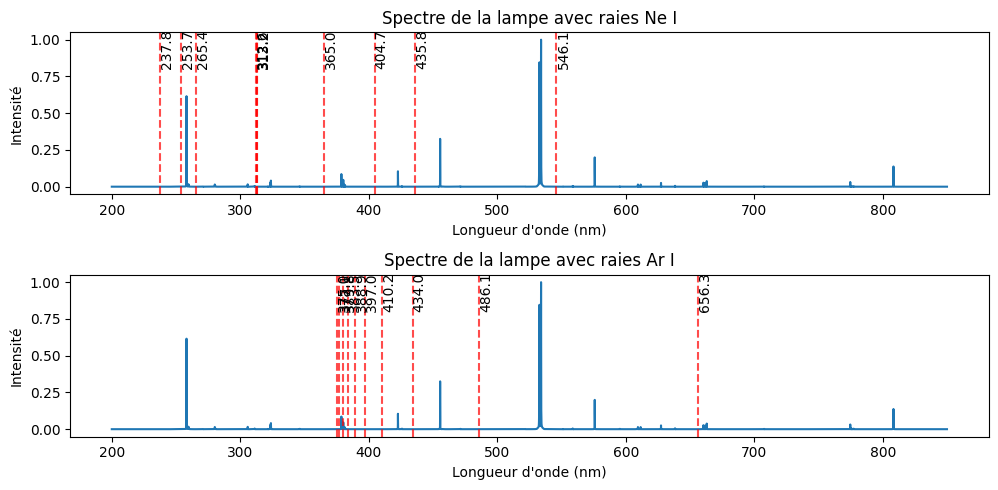

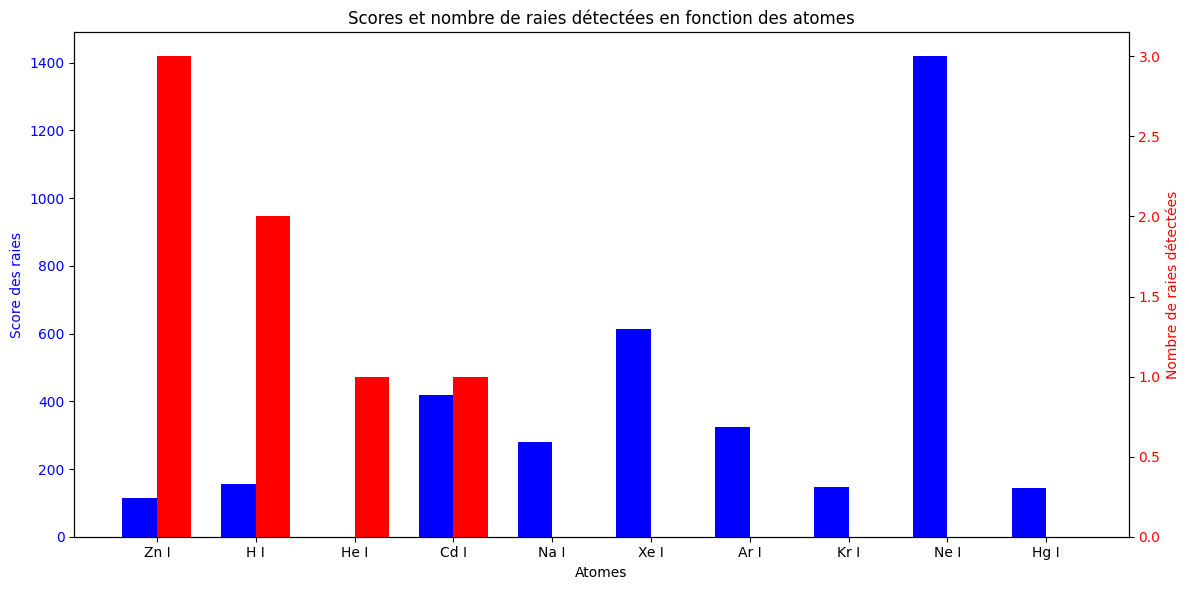

In [ ]:
def analyse_spectrum(filename, l_min=200, l_max=850, resolution=13.9072e-12, top=10, height=1e-2, cibles = ["Hg I", "H I", "He I", "Ne I", "Ar I", "Kr I", "Xe I", "Cd I", "Zn I", "Na I"], spectra_output=None, scores_output=None):
    """
    Analyse un spectre en détectant les raies et en les comparant aux raies cibles.

    Parameters:
    filename (str): Le nom du fichier contenant le spectre.
    l_min (float): La longueur d'onde minimale du spectre.
    l_max (float): La longueur d'onde maximale du spectre
    resolution (float): La résolution du spectre.
    top (int): Le nombre de raies à récupérer pour chaque atome.    
    height (float): La hauteur minimale des pics à détecter.
    """
    
    # Charger le spectre
    data = imageio.imread(filename)
    spectrum = np.sum(data, axis=0)
    spectrum /= max(spectrum) # Normalisation de l'intensité
    
    # Créer les longueurs d'onde correspondantes
    longueurs_onde = np.linspace(l_min, l_max, len(spectrum))
    
    # Extraire les raies du spectre
    peaks = extract_raies(spectrum, height=height)
    raies_detectees = longueurs_onde[peaks]
    
    
    print(f"Nombre de raies détectées: {len(raies_detectees)}")
    
    # Récupérer les raies cibles
    rays = [get_best_rays(atom, l_min=l_min, l_max=l_max, top=top)[0] for atom in cibles]
    
    # Calculer les scores et le nombre de matchs
    scores = [score_rays(raies_detectees, raies_atom) for raies_atom in rays]
    nb_matches = [get_nb_matches(raies_detectees, raies_atom) for raies_atom in rays]
    
    print(f"Scor Hg " + str(scores[0]))
    print(f"Nb match Hg " + str(nb_matches[0]))
    
    # Affichage des résultats
    plot_spectra_with_rays(spectrum, longueurs_onde, rays, spectra_output)
    plot_scores_and_matches(cibles, scores, nb_matches, scores_output)
    
    return scores, nb_matches
    
scores, nb_matches = analyse_spectrum(os.path.join(data_folder, "20250314_g10_f0-01_r1200BLZ_w50ms_l2.SPE"), l_min=200, l_max=850, height=5e-3)